# Tarea PySpark

### Objetivo:
 Analizar la eficiencia de los jugadores en términos generales y por posición, así como determinar la contribución al equipo por jugador tomando en cuenta los datos obtenidos

Usarás la base de datos del archivo 'fusbol.csv' para obtener tus datos. Checa la estructura del archivo para ver si es necesario limpiar la informacion, ver su estructura y así sea más fácil completar la tarea. Besos.

### Ejercicio 1:
Carga la base de datos en un DataFrame de Pyspark (con 2 nucleos). Valida los rangos de los valores donde sea aplicable, así como su corrección (en caso de ser necesaria). 
Después, utilizando las variables más relevantes como 'Ast/90', 'PassCmp%', etc., concluye qué ligas tienen los mejores jugadores por posición. Es decir, si los mejores jugadores defensas son de la liga francesa, inglesa, etc., por ejemplo.
Como cada persona tiene una definición de "mejor", utiliza las siguientes metricas por posición:
- Delanteros: npG+A/90 y npxG+xA/90
- Medios: KeyPass/90 y PassCmp%
- Defensas: PressSucc% y Interceptions/90

Con los resultados obtenidos, grafica por posición para que tu conclusión tenga un respaldo visual también.

In [179]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore

In [180]:
spark = SparkSession.builder.appName('firstSession')\
    .config('spark.master', 'local[2]')\
    .config('spark.executor.memory', '1g')\
    .config("spark.sql.shuffle.partitions", 10)\
    .config('spark.driver.memory','1g')\
    .getOrCreate()

In [181]:
spark

In [182]:
df = spark.read.csv('fusbol.csv', header=True, inferSchema=True)

In [183]:
df.show()

+-------------------+-------+---+---------------+------------------+----+------+---+------+----+----+------+------+--------+-----+-------+----------+--------+-------+-----+--------+-------+-----------+--------+---------+-------+----------+----------+--------+--------------+--------------+-----------+-----------+---------+---------+---------+-------+----------+----------+--------+----------+----------------+--------------+---------------+-----------+--------------+--------------+------------+--------+-----------------+-----------+----------+-------------+----------+-----------+-----------+------------+-----------+------------+----------------+--------------+------------+------------+------------+------+--------------+--------------+----------+--------+----------+---------+------+--------------+--------------+----------+--------+----------+---------+---------+-------+-------------+-------------+-------------+------------+--------------+---------+-----------+-----------+------------+-----

In [184]:
df.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Nation: string (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Squad: string (nullable = true)
 |-- Comp: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Born: double (nullable = true)
 |-- MP: integer (nullable = true)
 |-- Starts: integer (nullable = true)
 |-- Min: integer (nullable = true)
 |-- 90s: double (nullable = true)
 |-- Ast/90: double (nullable = true)
 |-- npG/90: double (nullable = true)
 |-- npG+A/90: double (nullable = true)
 |-- xA/90: double (nullable = true)
 |-- npxG/90: double (nullable = true)
 |-- npxG+xA/90: double (nullable = true)
 |-- Shots/90: double (nullable = true)
 |-- SoTs/90: double (nullable = true)
 |-- SoT%: double (nullable = true)
 |-- Gls/Shot: double (nullable = true)
 |-- Gls/SoT: double (nullable = true)
 |-- AvgShotDist: double (nullable = true)
 |-- FKSht/90: double (nullable = true)
 |-- npxG/Shot: double (nullable = true)
 |-- np:G-xG: double (nullable = true)
 |--

In [185]:
df= df.dropna()

In [186]:
delanteros= df.filter(df["Pos"] == "FW").groupby("Comp").agg(
    avg("npG+A/90").alias("Promedio_npG_A_90"),
    avg("npxG+xA/90").alias("Promedio_npxG_xA_90")
).orderBy(("Promedio_npG_A_90"), ("Promedio_npxG_xA_90"))

delanteros.show()

medios = df.filter(df["Pos"] == "MF").groupby("Comp").agg(
    avg(df["KeyPass/90"]).alias("Promedio_KeyPass_90"),
    avg(df["PassCmp%"]).alias("Promedio_PassCmp_porcentaje")
).orderBy(("Promedio_KeyPass_90"), ("Promedio_PassCmp_porcentaje"))
medios.show()


defensas= df.filter(df["Pos"] == "DF").groupby("Comp").agg(
    avg(df["PressSucc%"]).alias("Promedio_PressSucc_porcentaje"),
    avg(df["Interceptions/90"]).alias("Promedio_Interceptions_90")
).orderBy(("Promedio_PressSucc_porcentaje"), ("Promedio_Interceptions_90"))
defensas.show()

+------------------+-------------------+-------------------+
|              Comp|  Promedio_npG_A_90|Promedio_npxG_xA_90|
+------------------+-------------------+-------------------+
|        es La Liga| 0.3805555555555556|0.38888888888888895|
|        fr Ligue 1| 0.4401785714285715| 0.4348214285714285|
|eng Premier League|0.45999999999999996|0.47933333333333333|
|        it Serie A|0.49342857142857144| 0.4784285714285715|
|     de Bundesliga| 0.5116666666666668| 0.5014285714285713|
+------------------+-------------------+-------------------+

+------------------+-------------------+---------------------------+
|              Comp|Promedio_KeyPass_90|Promedio_PassCmp_porcentaje|
+------------------+-------------------+---------------------------+
|     de Bundesliga| 0.8617543859649119|          80.58596491228066|
|        fr Ligue 1| 0.8863291139240508|          83.48354430379747|
|        es La Liga| 0.8935365853658536|          80.31463414634146|
|        it Serie A| 1.0096039603960

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

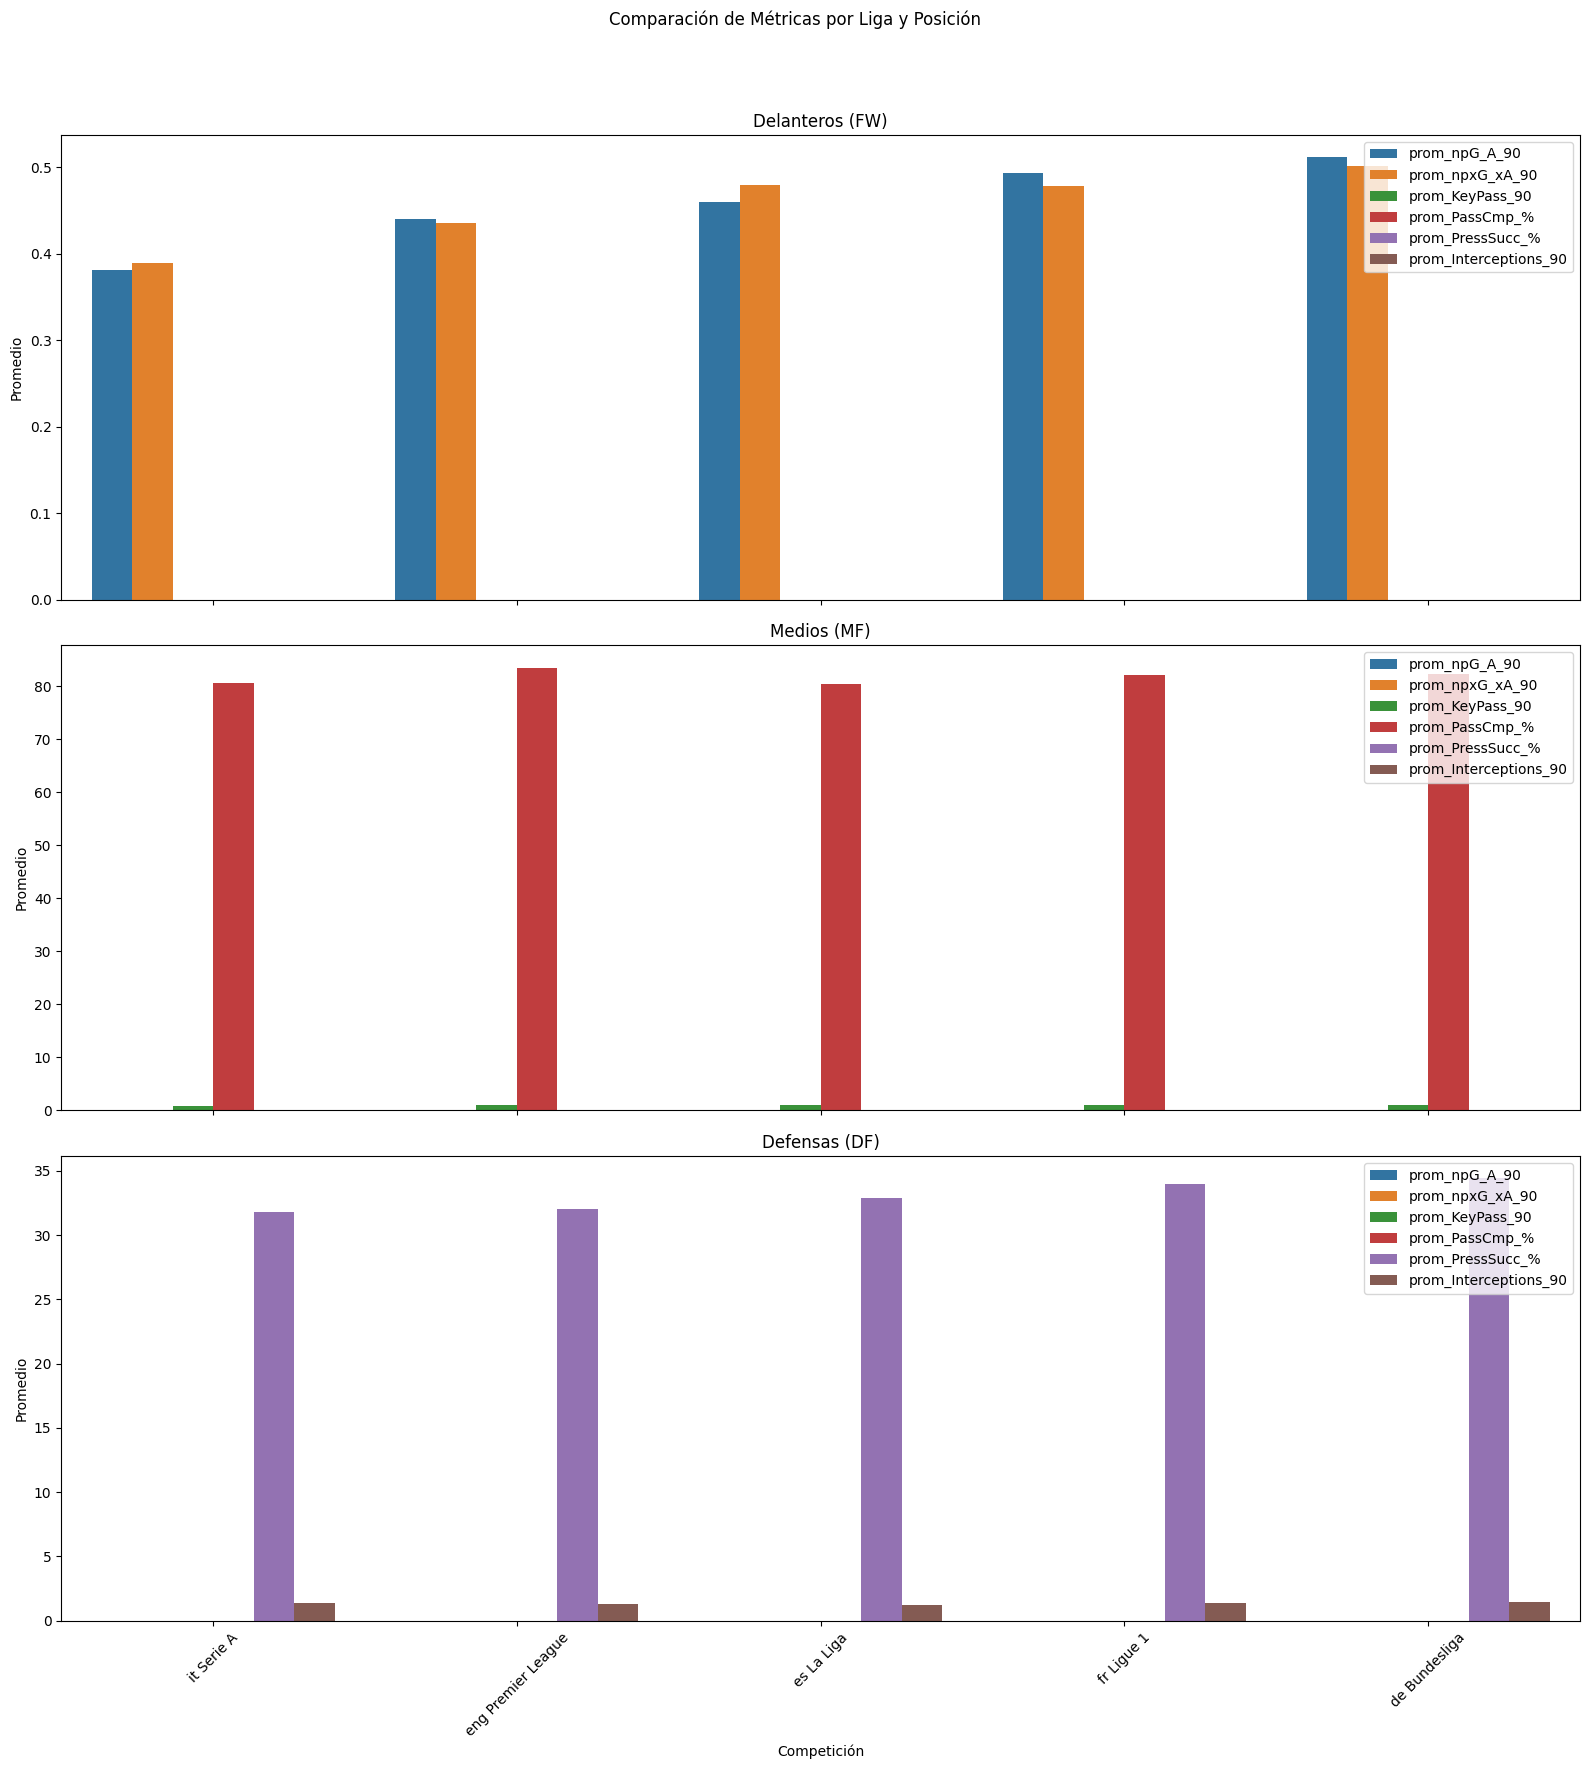

In [187]:
delanteros_pd = delanteros.toPandas()
medios_pd = medios.toPandas()
defensas_pd = defensas.toPandas()

# Añadir columna de posición
delanteros_pd['Pos'] = 'FW'
medios_pd['Pos'] = 'MF'
defensas_pd['Pos'] = 'DF'

# Unir los DataFrames
combined_df = pd.concat([delanteros_pd, medios_pd, defensas_pd])

# Renombrar las columnas para facilitar el graficado
combined_df = combined_df.rename(columns={
    'Promedio_npG_A_90': 'prom_npG_A_90',
    'Promedio_npxG_xA_90': 'prom_npxG_xA_90',
    'Promedio_KeyPass_90': 'prom_KeyPass_90',
    'Promedio_PassCmp_porcentaje': 'prom_PassCmp_%',
    'Promedio_PressSucc_porcentaje': 'prom_PressSucc_%',
    'Promedio_Interceptions_90': 'prom_Interceptions_90'
})


df_long = pd.melt(combined_df, id_vars=['Comp', 'Pos'], 
                  value_vars=['prom_npG_A_90', 'prom_npxG_xA_90', 'prom_KeyPass_90', 'prom_PassCmp_%', 'prom_PressSucc_%', 'prom_Interceptions_90'],
                  var_name='Metric', value_name='Value')


df_long_fw = df_long[df_long['Pos'] == 'FW']
df_long_mf = df_long[df_long['Pos'] == 'MF']
df_long_df = df_long[df_long['Pos'] == 'DF']

# Graficar
fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)

sns.barplot(data=df_long_fw, x='Comp', y='Value', hue='Metric', ax=axes[0])
axes[0].set_title('Delanteros (FW)')
axes[0].set_ylabel('Promedio')
axes[0].legend(loc='upper right')

sns.barplot(data=df_long_mf, x='Comp', y='Value', hue='Metric', ax=axes[1])
axes[1].set_title('Medios (MF)')
axes[1].set_ylabel('Promedio')
axes[1].legend(loc='upper right')

sns.barplot(data=df_long_df, x='Comp', y='Value', hue='Metric', ax=axes[2])
axes[2].set_title('Defensas (DF)')
axes[2].set_ylabel('Promedio')
axes[2].legend(loc='upper right')

plt.xticks(rotation=45)
plt.xlabel('Competición')
plt.suptitle('Comparación de Métricas por Liga y Posición')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Ejercicio 2:

Ahora hagamos algo un poco más interesante. Escoge algún jugador de todos los disponibles y toma 5 metricas, las que quieras. Debes concluir en qué percentil se encuentra el jugador en esas métricas que escogiste. Obviamente, vas a comparar sus valores con todos los demás con los que comparte posición y liga, para no tener un sesgo y que la información no pierda robustez. Por último, genera un DataFrame de Pyspark con todos los datos solicitados. Muestra el DataFrame y conviertelo a otro de tipo pandas. Muestra los dos.

In [188]:
jugador = df.first()
print(jugador)


Row(Player='Patrick van Aanholt', Nation='nl NED', Pos='DF', Squad='Crystal Palace', Comp='eng Premier League', Age=29.0, Born=1990.0, MP=22, Starts=20, Min=1777, 90s=19.7, Ast/90=0.05, npG/90=0.0, npG+A/90=0.05, xA/90=0.04, npxG/90=0.06, npxG+xA/90=0.1, Shots/90=0.91, SoTs/90=0.3, SoT%=33.3, Gls/Shot=0.0, Gls/SoT=0.0, AvgShotDist=20.3, FKSht/90=0.15, npxG/Shot=0.07, np:G-xG=-0.06, PassCmp/90=45.1, PassAtt/90=57.2, PassCmp%=78.9, TotDistPass/90=756.6, PrgDistPass/90=352.5, ShortCmp/90=23.0, ShortAtt/90=26.0, ShortCmp%=88.7, MedCmp/90=17.3, MedAtt/90=21.2, MedCmp%=81.3, LongCmp/90=3.96, LongAtt/90=7.66, LongCmp%=51.7, KeyPass/90=0.56, PassIntoThird/90=3.45, PassIntoBox/90=1.32, CrossIntoBox/90=0.2, ProgPass/90=5.69, LivePassAtt/90=47.3, DeadPassAtt/90=9.9, FKPassAtt/90=1.83, TBCmp/90=0.1, PassUnderPress/90=5.69, Switches/90=1.02, Crosses/90=1.73, GroundPass/90=36.4, LowPass/90=11.1, HighPass/90=9.7, LeftPass/90=37.7, RightPass/90=9.85, HeadPass/90=1.27, ThrowPass/90=7.97, OtherPartPass/

In [189]:
jugador = 'Patrick van Aanholt'
pos = 'DF'
liga = 'eng Premier League'
metricas = ['npG/90', 'npxG+xA/90', 'SoT%', 'AvgShotDist', 'PassCmp%']

df_jug = df.filter((df['Player'] != jugador) & (df['Pos'] == pos) & (df['Comp'] == liga)).select(metricas)

# Convertir el DataFrame de PySpark a pandas para calcular los percentiles
df_jug_pd = df_jug.toPandas()

# Obtener los datos del jugador específico
player_data = df.filter((df['Player'] == jugador) & (df['Pos'] == pos) & (df['Comp'] == liga)).select(metricas).toPandas().iloc[0]

# Calcular y mostrar los percentiles para cada métrica
print(f'Percentiles de {jugador} en comparación con otros {pos} en {liga}:\n')
for col in metricas:
    percentile = percentileofscore(df_jug_pd[col], player_data[col])
    print(f'{col}: {percentile:.2f}\n')

Percentiles de Patrick van Aanholt en comparación con otros DF en eng Premier League:

npG/90: 16.52

npxG+xA/90: 68.75

SoT%: 55.80

AvgShotDist: 79.46

PassCmp%: 41.07



In [190]:
#DataFrame de PySpark
df_jug.show()

+------+----------+----+-----------+--------+
|npG/90|npxG+xA/90|SoT%|AvgShotDist|PassCmp%|
+------+----------+----+-----------+--------+
|   0.0|      0.04|25.0|        8.8|    87.4|
|  0.07|      0.08|28.6|       25.2|    77.7|
|  0.06|       0.1|37.5|       19.7|    91.3|
|  0.06|      0.05|30.8|        9.0|    74.4|
|  0.04|      0.05|27.3|        7.6|    83.7|
|  0.06|      0.32|19.6|       23.7|    75.3|
|  0.07|      0.17|32.0|       18.6|    80.1|
|  0.19|      0.27|40.9|       17.2|    81.6|
|  0.12|      0.05|33.3|       10.8|    85.8|
|  0.03|      0.05|23.1|       15.4|    89.7|
|  0.11|      0.18|42.9|       16.4|    80.6|
|   0.0|       0.1|24.0|       18.6|    79.3|
|  0.04|      0.14|36.4|       16.1|    87.5|
|  0.08|      0.05|25.0|        9.6|    76.8|
|   0.0|      0.09|15.4|       16.5|    78.5|
|   0.1|      0.08|35.7|        8.2|    77.9|
|  0.03|      0.04|50.0|        8.9|    84.6|
|  0.04|      0.14|33.3|       19.1|    82.9|
|   0.0|      0.06|37.5|       19.

In [191]:
#DataFrame de Pandas

In [192]:
print(df_jug_pd)

     npG/90  npxG+xA/90   SoT%  AvgShotDist  PassCmp%
0      0.00        0.04   25.0          8.8      87.4
1      0.07        0.08   28.6         25.2      77.7
2      0.06        0.10   37.5         19.7      91.3
3      0.06        0.05   30.8          9.0      74.4
4      0.04        0.05   27.3          7.6      83.7
..      ...         ...    ...          ...       ...
107    0.00        0.02   50.0         24.8      72.7
108    0.03        0.05   25.0         12.7      82.7
109    0.00        0.06  100.0         12.0      85.7
110    0.00        0.13   25.0         21.9      90.2
111    0.22        0.08   44.4         12.2      91.9

[112 rows x 5 columns]
